# Classification of spoken digits with snnTorch

Developed by [Fredrik Sandin](https://www.ltu.se/staff/f/fresan-1.10646?l=en). 

In this exercise you will learn how to load and transform an event dataset of speech and develop a spiking neural network for classification of spoken digits using snnTorch. See the related tutorials and lecture material referenced in Canvas for background information.

There are 3 ***mandatory tasks*** and 1 *optional task* in this exercise.

## 1 Import libraries
Unless you have already done so, you must first install snnTorch, Tonic, and matplotlib to run this exercise.

In [1]:
!pip install snntorch
!pip install tonic
!pip install matplotlib

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import snntorch as snn

import tonic
from tonic import DiskCachedDataset
import tonic.transforms as transforms

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from snntorch.functional import ce_count_loss, ce_rate_loss, accuracy_rate
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\Development Lab\Documents\SNN Lab 1\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 Loading event data with Tonic

In this exercise you will load an event-based dataset using [Tonic](https://github.com/neuromorphs/tonic), which provides some publicly available event-based vision and audio datasets and event transformations. The package is compatible with snnTorch/PyTorch.

This exercise focuses on classifying spoken digits in the [Spiking Heidelberg Digits (SHD)](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) dataset, which includes approximately 10000 high-quality aligned studio recordings of spoken digits from 0 to 9 in both German and English language from 12 distinct speakers, out of which two speakers are only present in the test set. Each digit is represented by spikes on 700 channels which were generated using [Lauscher](https://github.com/electronicvisions/lauscher), a neuromorphic [cochlea](https://iopscience.iop.org/article/10.1088/2634-4386/ac4a83#nceac4a83s47) software model. The SHD webpage referenced above includes a leader board and the data set is presented in the following paper.

Cramer, B., Stradmann, Y., Schemmel, J., and Zenke, F. (2022).
*The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks*.
IEEE Transactions on Neural Networks and Learning Systems 33, 2744–2757.
[https://doi.org/10.1109/TNNLS.2020.3044364](https://doi.org/10.1109/TNNLS.2020.3044364).

Recent work by Boeshertz et al. (https://arxiv.org/abs/2407.13534) has show that it can be preferable to use adaptive LIF neurons to generate spikes from the original Heidelberg Digits data, both w.r.t. precision and data reduciton. For those of you who want to are ambiitons and want to expand your knowledge beyond the course content, read this paper, evaluate the proposed neuron model and hypothesize why it generates better spiking data than the alternative we load in this exercise.

### 2.1 Load the training dataset and plot samples
The SHD training set includes 8156 spoken digit samples. Each digit is represented by an array of events which consists of three parameters (timestamp t, cochlea channel number x, polarity p). Plot the spike representations of five different samples of one particular digit. What are the different channels representing? What is the time duration of the patterns? Why are the patterns different although the same digit is spoken?

***Mandatory task 1:***

Extend the code below so that it plots one digit sample for each of the 20 classes in the dataset. Thus, the subplot should have 20 panels. Each panel should illustrate one sample of one particular digit. Plot different samples and analyse the variations. Are different samples of one and the same digit similar or different? Why?

In [3]:
dataset = tonic.datasets.SHD(save_to='./shd', train=True)
sensor_size = dataset.sensor_size
print("Sensor size (# channels):", sensor_size)
print("Number of training samples:", len(dataset))
print("Event representation: ", dataset.dtype)
print("Classes:", [c.decode('UTF-8') for c in dataset.classes])

130864128it [00:33, 3934551.88it/s]                               


Extracting ./shd\SHD\shd_train.h5.zip to ./shd\SHD
Sensor size (# channels): (700, 1, 1)
Number of training samples: 8156
Event representation:  [('t', '<i4'), ('x', '<i4'), ('p', '<i4')]
Classes: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'null', 'eins', 'zwei', 'drei', 'vier', 'fuenf', 'sechs', 'sieben', 'acht', 'neun']


Digit zero is represented by 5676 events
Digit one is represented by 10561 events
Digit two is represented by 6604 events
Digit three is represented by 4274 events
Digit four is represented by 7934 events
Digit five is represented by 4896 events
Digit six is represented by 6144 events
Digit seven is represented by 12023 events
Digit eight is represented by 8927 events
Digit nine is represented by 12889 events
Digit null is represented by 10088 events
Digit eins is represented by 4278 events
Digit zwei is represented by 7000 events
Digit drei is represented by 12118 events
Digit vier is represented by 7071 events
Digit fuenf is represented by 5078 events
Digit sechs is represented by 5568 events
Digit sieben is represented by 8816 events
Digit acht is represented by 9162 events
Digit neun is represented by 6401 events


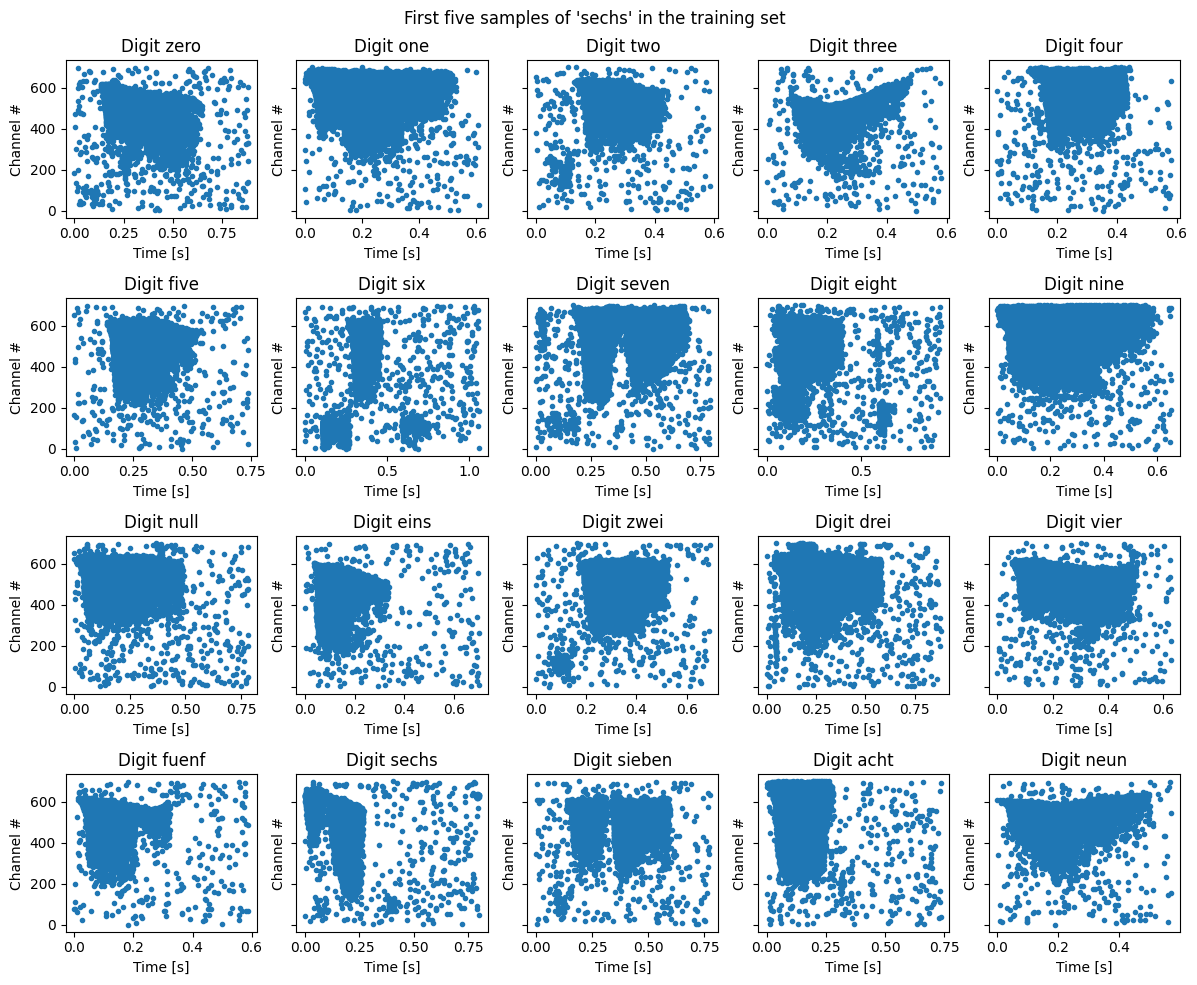

In [4]:
index = 0
samples = 0
digit = "sechs"
fig, axs = plt.subplots(4,5, figsize=(12,10),sharey=True)
fig.suptitle(f"First five samples of '{digit}' in the training set")
for ax_idx, ax in enumerate(axs.flatten()):
    digit = dataset.classes[ax_idx].astype(str)
    while samples < 1: # want to gather 5 samples
        events, label = dataset[index] # get events and label of current sample
        if dataset.classes[label].decode('UTF-8') == digit: # if label of current sample is target label then
            ax.scatter(1e-6*events['t'], events['x'], marker=".") 
            ax.invert_yaxis()
            ax.set_title(f"Digit {digit}")
            ax.set_xlabel("Time [s]")
            ax.set_ylabel("Channel #")
            print(f"Digit {digit} is represented by {len(events)} events")
            samples += 1 # we have one more sample
        index += 1 # try next sample
    
    samples = 0
    index = 0

fig.tight_layout()

In [5]:
events

array([(     0, 607, 1), (  2458, 340, 1), (  9582,  98, 1), ...,
       (565918, 698, 1), (567382, 547, 1), (569824, 152, 1)],
      dtype=[('t', '<i4'), ('x', '<i4'), ('p', '<i4')])

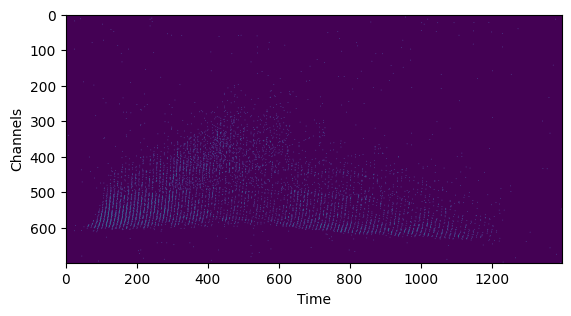

In [6]:
# Tonic provides an event plotting function that can also be used (Time in ms), which rasterizes the events and displays the result with imshow().
tonic.utils.plot_event_grid(events)

### 2.2 Downsample the digits and create a dataloader

Now you are familiar with the samples in the dataset. It is time to prepare the digits in a format that is suitable for snnTorch experiments on a PC. To obtain state-of-the-art results we would need to keep a high spatial and temporal resolution of the digits. However, with 700 input channels the simulations would take far too long time if we process the full-resolution digits.

We can choose a set of transforms to apply to our data before feeding it to an SNN. Here we [Downsample](https://tonic.readthedocs.io/en/main/autoapi/tonic/transforms/index.html#tonic.transforms.Downsample) the events to 70 channels instead of 700, which reduces the dimension of the resulting tensor representations. Furthermore, we use the [toFrame](https://tonic.readthedocs.io/en/main/generated/tonic.transforms.ToFrame.html#tonic.transforms.ToFrame) transformation with time-binning over 10000 microseconds, which results in a sequence of 10-millisecond long frames with 70 channels each.
 
To speed up dataloading, we can make use of disk caching and batching. That means that once the files are loaded from the original dataset they are written to the disk. Because the event arrays have different lengths, we are going to use a collation function tonic.collation.PadTensors() that will pad shorter recordings to ensure all tensors in a batch have the same dimensions.

If you need to refresh basic machine learning concepts such as "batch" and "training set" a good reference is the [Deep Learning](https://www.deeplearningbook.org/) book, which is part of the course literature in the [D7046E Neural networks and learning machines](https://www.ltu.se/edu/course/D70/D7046E/D7046E-Neuronnat-och-larande-maskiner-1.183276?kursView=kursplan&l=en) course.

In [2]:
import os, shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import snntorch as snn

import tonic
from tonic import DiskCachedDataset
import tonic.transforms as transforms


In [3]:
batch_size = 64 # Keeping this small for clarity of the examples below, you may need to increase it later
sensor_size = 700
use_downsampling = True
# OBS: You must first delete the cache files before running this with new parameters/transforms, otherwise there is no effect of modified hyperparameters

transforms_arr = []
if use_downsampling:
    spatial_factor = 0.1 # --> 1
    transforms_arr.append(
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=spatial_factor), # 70 channels
    )

time_window = 10000 # --> 1
new_size = int(spatial_factor * sensor_size)

transforms_arr.append(
    transforms.ToFrame(sensor_size=(new_size,1,1),time_window=time_window) # us to 10 ms
)
 
if os.path.exists("./data"):
    shutil.rmtree("./data")
if os.path.exists("./shd"):
    shutil.rmtree("./shd")

trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose(transforms_arr)
)

testset = tonic.datasets.SHD(
    save_to='./data',
    train=False,
    transform=transforms.Compose(transforms_arr)
)

cached_trainset = DiskCachedDataset(
    trainset,
    cache_path='./data/cache/shd/train',
    transform=torch.from_numpy
)

cached_testset = DiskCachedDataset(
    testset,
    cache_path='./data/cache/shd/test',
    transform=torch.from_numpy
)

trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size, 
    collate_fn=tonic.collation.PadTensors(),
    drop_last=True
)

testloader = DataLoader(
    cached_testset,
    batch_size=batch_size, 
    collate_fn=tonic.collation.PadTensors(),
    drop_last=True
)

trainiter = iter(trainloader)
testiter = iter(testloader)

# Function that returns the next batch from the training set
def load_training_batch():
    events, targets = next(trainiter)    
    # snnTorch torch uses time-first tensors, which means [time x batch_size x feature_dimensions].
    # Convert from the default [batch_size x time x 1 x channels] frame representation in the dataset:
    events = events.transpose(0,1).squeeze()
    return (events, targets)

130864128it [00:12, 10694714.32it/s]                               


Extracting ./data\SHD\shd_train.h5.zip to ./data\SHD


38141952it [00:03, 10663116.66it/s]                              


Extracting ./data\SHD\shd_test.h5.zip to ./data\SHD


## Helper fuction for mandatory task 2

In [4]:
def create_dataloader(batch_size = 64, sensor_size = 700, use_downsampling = True, use_timebinning = True):
    for path in ["./data", "./shd"]:
        if os.path.exists(path):
            shutil.rmtree(path)

    transforms_arr = []
    if use_downsampling:
        spatial_factor = 0.1 # --> 1
        transforms_arr.append(
            transforms.Downsample(sensor_size=sensor_size, spatial_factor=spatial_factor), # 70 channels
        )  
        sensor_size = int(spatial_factor * sensor_size)

    if use_timebinning:
        time_window = 10000
        transforms_arr.append(
            transforms.ToFrame(sensor_size=(sensor_size, 1, 1), time_window=time_window)
        )
    else:
        time_window = 1
        transforms_arr.append(
            transforms.ToFrame(sensor_size=(sensor_size, 1, 1), time_window=time_window)
        )

    trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose(transforms_arr)
    )

    testset = tonic.datasets.SHD(
        save_to='./data',
        train=False,
        transform=transforms.Compose(transforms_arr)
    )

    """
    cached_trainset = DiskCachedDataset(
        trainset,
        cache_path='./data/cache/shd/train',
        transform=torch.from_numpy,
        reset_cache=True
    )

    cached_testset = DiskCachedDataset(
        testset,
        cache_path='./data/cache/shd/test',
        transform=torch.from_numpy,
        reset_cache=True
    )
    """

    trainloader = DataLoader(
        # cached_trainset,
        trainset,
        batch_size=batch_size, 
        collate_fn=tonic.collation.PadTensors(),
        drop_last=True
    )

    testloader = DataLoader(
        # cached_testset,
        testset,
        batch_size=batch_size, 
        collate_fn=tonic.collation.PadTensors(),
        drop_last=True
    )

    return trainloader, testloader

### 2.3 Load one batch and visualize the downsampled digits 

Shape of batch with 64 digits:  torch.Size([115, 64, 70])


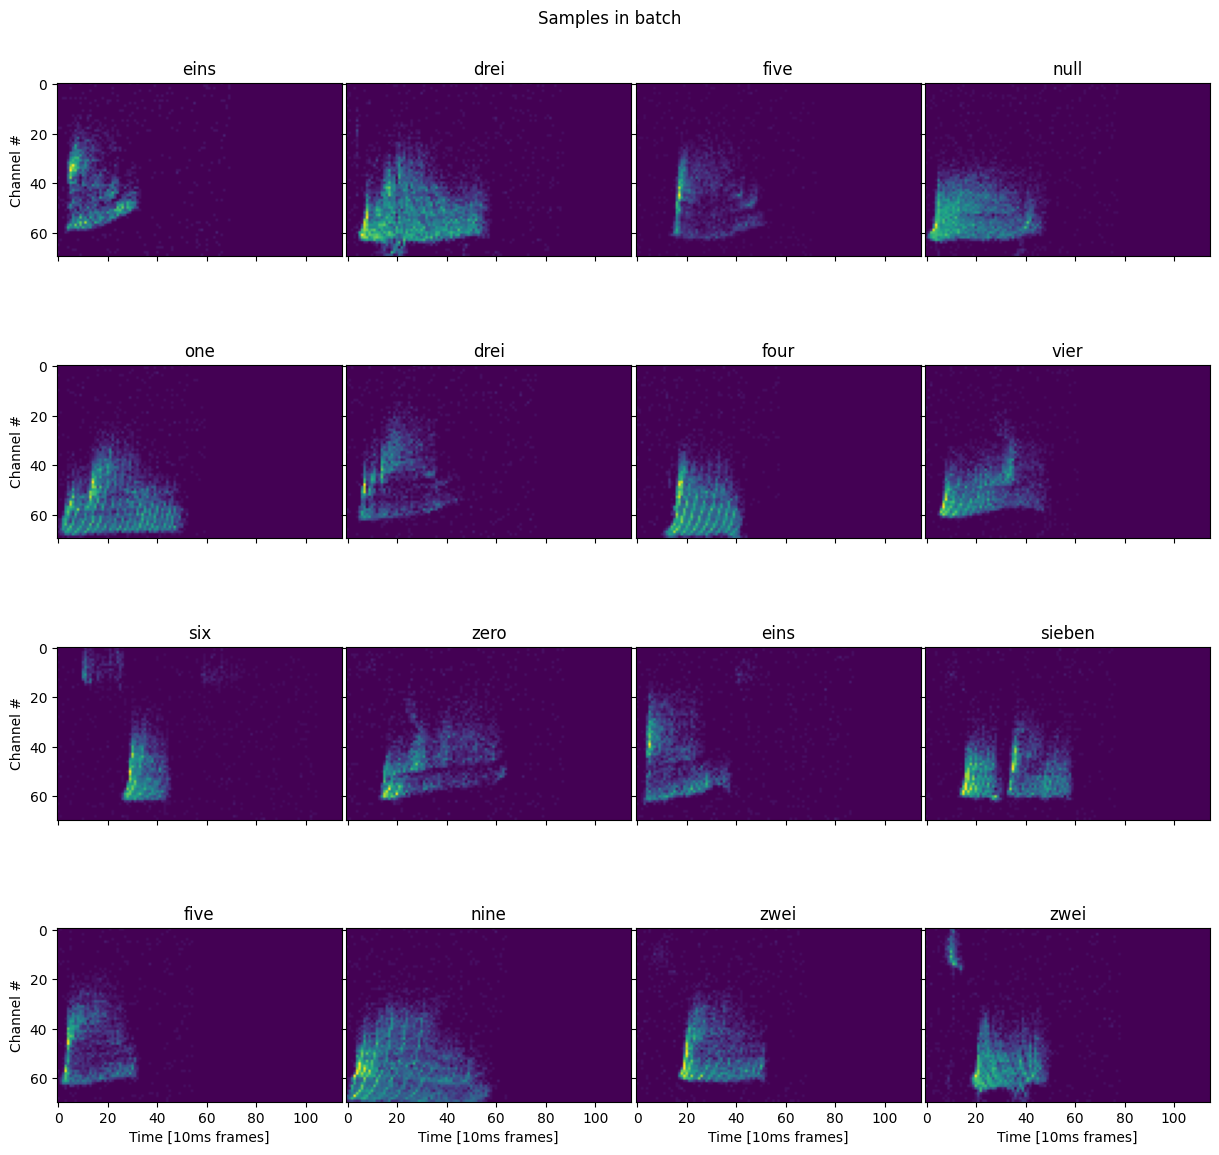

In [8]:
# Enable plotting of tensors with matplotlib
torch.Tensor.ndim = property(lambda self: len(self.shape))

events, target = load_training_batch()
print(f"Shape of batch with {batch_size} digits: ", events.shape)

fig,axs = plt.subplots(4,4,figsize=(12,12),sharex=True, sharey=True)
fig.suptitle(f"Samples in batch")

for i in range(4):
    axs[i,0].set_ylabel('Channel #')
    for j in range(4):
        index = i*4+j
        tensor = events[:,index,:].transpose(0,1)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.tight_layout(pad=0)
plt.show()

## 3 Processing of digits with a feed-forward SNN

The following is an adaptation of the feed-forward SNN example presented in the snnTorch [tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_3.html). The following code implements a feed-forward SNN that processes the downsampled digits in the SHD trainset visualized above. The code illustrates the principle of how to
   * Run a basic SNN simulation with SHD input data
   * Visualize the resulting spikes in the hidden and output layer

### 3.1 Run SNN simulation over timesteps in the batch

***Mandatory task 2:*** How much longer is the simulation time of one forward pass if the original number of channels (700) in the dataset is used? Does the time-binning introduced by the toFrame transformation reduce simulation time? Run simulations to validate your analysis.

downsample: 700 -> 70 channels
timebinning: count all events in 10ms

In [9]:
import time

In [10]:
num_timesteps = events.shape[0]     # Number of timesteps in the longest-duration digit
num_samples = events.shape[1]       # Number of digits in batch
num_channels = events.shape[2]      # Number of channels in downsampled digits
num_classes = len(trainset.classes)

# SNN hyperparameters
beta = 0.95
num_inputs = num_channels
num_outputs = num_classes
hidden_sizefac = 2        # Size of hidden layer in relation to size of input layer

# Define first hidden layer and input connections
fc1 = nn.Linear(num_inputs, hidden_sizefac*num_channels)
lif1 = snn.Leaky(beta=beta)

# Define output layer with inputs from hidden layer
fc2 = nn.Linear(hidden_sizefac*num_channels, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize neuron states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# Placeholders for outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []
start_time = time.time()
# Run network simulation over all timesteps in the input tensor
for step in range(num_timesteps):

    cur1 = fc1(events[step,:,:])  # post-synaptic current to hidden <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem1[t+1] <--post-syn current contrib + decayed membrane
    cur2 = fc2(spk1)              # post-synaptic current to output neurons
    spk2, mem2 = lif2(cur2, mem2) # output

    # Store states for analysis and plotting
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)
    mem2_rec.append(mem2)
finish_time = time.time()
# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

print("Hidden spikes shape", spk1_rec.shape)
print("Output spikes shape", spk2_rec.shape)
print("Output potential shape:", mem2_rec.shape)

Hidden spikes shape torch.Size([115, 64, 140])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])


In [11]:
import numpy as np
from tqdm import tqdm
use_timebinning = [True, False]
use_downsampling = [True, False]
cases = [
    {
        "timebinning": True,
        "downsampling": True,
        "time": []
    },
    {
        "timebinning": True,
        "downsampling": False,
        "time": []
    },
    {
        "timebinning": False,
        "downsampling": True,
        "time": []
    },
    
]
trials = 5
for case in cases:
    ds = case["downsampling"]
    tb = case["timebinning"]
    loader1, loader2 = create_dataloader(batch_size=64, sensor_size=700, use_downsampling=ds, use_timebinning=tb)
    data = next(iter(loader1))
    if not tb:
        trials = 1
    for trial in range(trials):

        events, labels = data
        events = events.squeeze().transpose(0,1)
        

        num_timesteps = events.shape[0]     # Number of timesteps in the longest-duration digit
        print(num_timesteps)
        num_samples = events.shape[1]       # Number of digits in batch
        num_channels = events.shape[2]      # Number of channels in downsampled digits
        num_classes = len(trainset.classes)

        # SNN hyperparameters
        beta = 0.95
        num_inputs = num_channels
        num_outputs = num_classes
        hidden_sizefac = 2        # Size of hidden layer in relation to size of input layer

        # Define first hidden layer and input connections
        fc1 = nn.Linear(num_inputs, hidden_sizefac*num_channels)
        lif1 = snn.Leaky(beta=beta)

        # Define output layer with inputs from hidden layer
        fc2 = nn.Linear(hidden_sizefac*num_channels, num_outputs)
        lif2 = snn.Leaky(beta=beta)

        # Initialize neuron states
        mem1 = lif1.init_leaky()
        mem2 = lif2.init_leaky()

        # Placeholders for outputs
        mem2_rec = []
        spk1_rec = []
        spk2_rec = []
        start_time = time.time()
        # Run network simulation over all timesteps in the input tensor
        for step in tqdm(range(num_timesteps)):

            cur1 = fc1(events[step,:,:])  # post-synaptic current to hidden <-- spk_in x weight
            spk1, mem1 = lif1(cur1, mem1) # mem1[t+1] <--post-syn current contrib + decayed membrane
            cur2 = fc2(spk1)              # post-synaptic current to output neurons
            spk2, mem2 = lif2(cur2, mem2) # output

            # Store states for analysis and plotting
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        finish_time = time.time()
        # Convert lists to tensors
        mem2_rec = torch.stack(mem2_rec)
        spk1_rec = torch.stack(spk1_rec)
        spk2_rec = torch.stack(spk2_rec)

        print("Hidden spikes shape", spk1_rec.shape)
        print("Output spikes shape", spk2_rec.shape)
        print("Output potential shape:", mem2_rec.shape)

        case["time"].append(finish_time - start_time)


130864128it [00:12, 10678744.97it/s]                               


Extracting ./data\SHD\shd_train.h5.zip to ./data\SHD


38141952it [00:03, 10626713.32it/s]                              


Extracting ./data\SHD\shd_test.h5.zip to ./data\SHD
115


100%|██████████| 115/115 [00:00<00:00, 1220.74it/s]


Hidden spikes shape torch.Size([115, 64, 140])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])
115


100%|██████████| 115/115 [00:00<00:00, 1226.01it/s]


Hidden spikes shape torch.Size([115, 64, 140])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])
115


100%|██████████| 115/115 [00:00<00:00, 1151.75it/s]


Hidden spikes shape torch.Size([115, 64, 140])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])
115


100%|██████████| 115/115 [00:00<00:00, 1191.34it/s]


Hidden spikes shape torch.Size([115, 64, 140])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])
115


100%|██████████| 115/115 [00:00<00:00, 1203.46it/s]


Hidden spikes shape torch.Size([115, 64, 140])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])


130864128it [00:12, 10727089.19it/s]                               


Extracting ./data\SHD\shd_train.h5.zip to ./data\SHD


38141952it [00:04, 8750162.07it/s]                               


Extracting ./data\SHD\shd_test.h5.zip to ./data\SHD
115


100%|██████████| 115/115 [00:00<00:00, 404.12it/s]


Hidden spikes shape torch.Size([115, 64, 1400])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])
115


100%|██████████| 115/115 [00:00<00:00, 350.01it/s]


Hidden spikes shape torch.Size([115, 64, 1400])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])
115


100%|██████████| 115/115 [00:00<00:00, 332.28it/s]


Hidden spikes shape torch.Size([115, 64, 1400])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])
115


100%|██████████| 115/115 [00:00<00:00, 342.68it/s]


Hidden spikes shape torch.Size([115, 64, 1400])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])
115


100%|██████████| 115/115 [00:00<00:00, 350.61it/s]


Hidden spikes shape torch.Size([115, 64, 1400])
Output spikes shape torch.Size([115, 64, 20])
Output potential shape: torch.Size([115, 64, 20])


130864128it [00:12, 10724404.31it/s]                               


Extracting ./data\SHD\shd_train.h5.zip to ./data\SHD


38141952it [00:04, 8916653.53it/s]                               


Extracting ./data\SHD\shd_test.h5.zip to ./data\SHD


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 20720000000 bytes.

In [12]:
for case in cases:
    print('---------------')
    print(f"Did {'' if case['downsampling'] else 'not'} use downsampling")
    print(f"Did {'' if case['timebinning'] else 'not'} use timebinning")
    print(f"Average time: {np.mean(case['time'])} seconds")
    print('---------------')
# cases

---------------
Did  use downsampling
Did  use timebinning
Average time: 0.0980903148651123 seconds
---------------
---------------
Did not use downsampling
Did  use timebinning
Average time: 0.3271622657775879 seconds
---------------
---------------
Did  use downsampling
Did not use timebinning
Average time: nan seconds
---------------


c:\Users\Development Lab\Documents\SNN Lab 1\venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Development Lab\Documents\SNN Lab 1\venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


We tried the case without timebinning, so that each event (x,y,z) gets converted into it's own frame. This results in a huge increase in the number of timesteps: 115 -> 1156250 as we now have a single timestep for every $\micro$s from the first event time till the last event time. On our computers we were not able to run it with the time window set to 1 as it took very long to compelte a single forward pass and impacted performance.

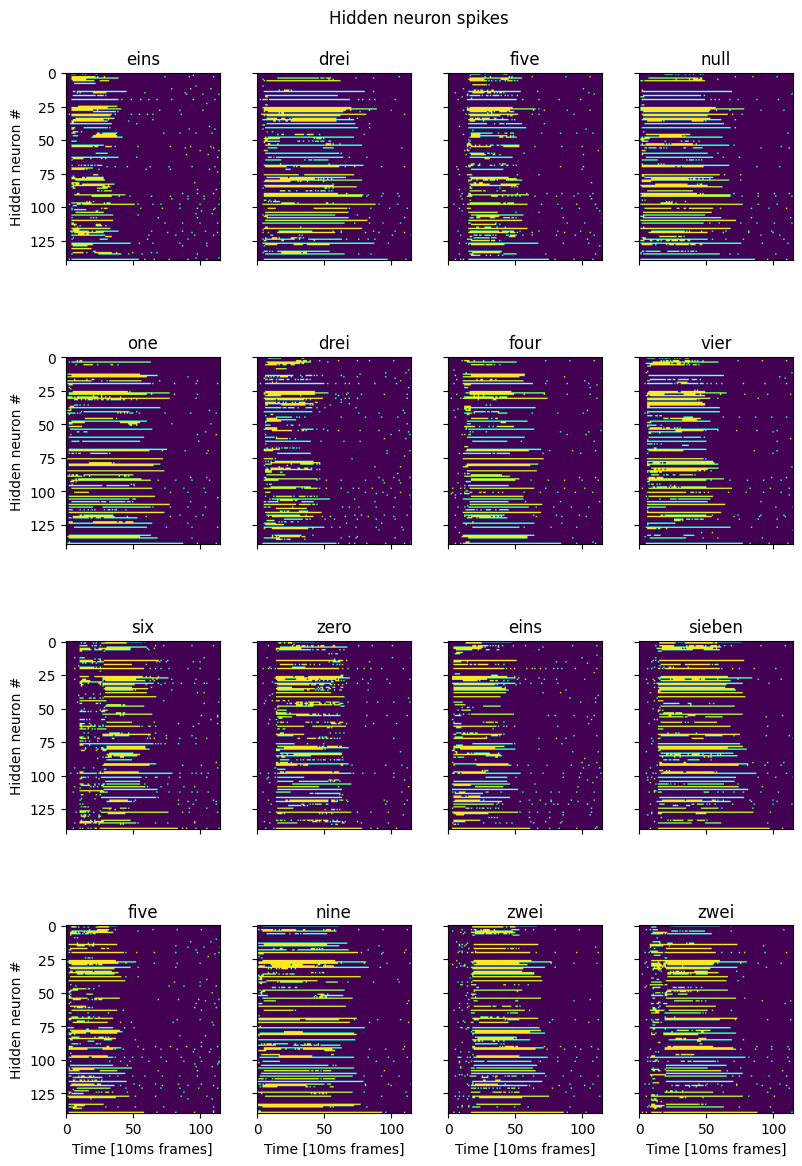

In [20]:
# Plot activity of hidden neurons for each input digit in the batch
s = spk1_rec.detach().numpy()
fig,axs = plt.subplots(4,4,figsize=(8,12),sharex=True,sharey=True)
fig.suptitle(f"Hidden neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i,0].set_ylabel('Hidden neuron #')
    for j in range(4):
        index = i*4+j
        tensor = s[:,index,:].squeeze().transpose(1,0)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.show()

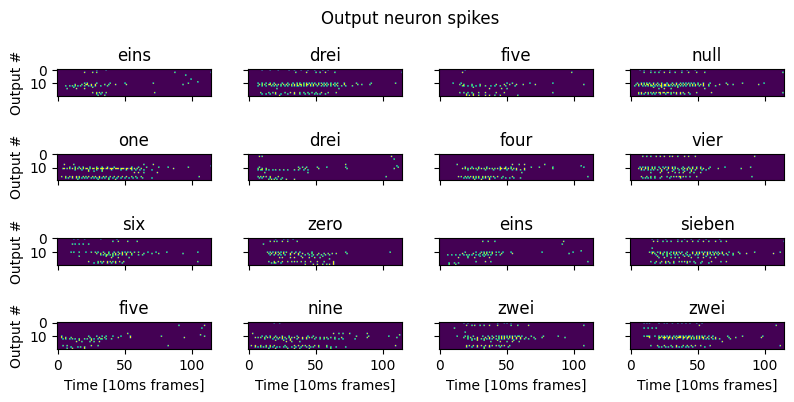

In [21]:
# Plot activity of output neurons for each input digit in the batch
s = spk2_rec.detach().numpy()
fig,axs = plt.subplots(4,4,figsize=(8,4),sharex=True,sharey=True)
fig.suptitle(f"Output neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i,0].set_ylabel('Output #')
    for j in range(4):
        index = i*4+j
        tensor = s[:,index,:].squeeze().transpose(1,0)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.show()

## 4 Train an SNN to classify the digits

***Mandatory task 3:***

Based on your understanding of the code above and the [snnTorch tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html) (and any other documented functions in snnTorch) that you think are required, develop and train a feed-forward SNN for classification of the 20 different digits in the SHD dataset.

The goal is that after training the 20 output neurons of the networks should differentiate between the 20 different digits in the training set, in the sense that for each target/class one particular output neuron is more likely to fire and/or fires with a higher spikerate than the other 19 neurons.

Note that you cannot directly copy the example in tutorial 5 because the SHD digits have varying duration in time (while the MNIST samples in the tutorial have fixed dimensionality and consequently the inputs could be flattened to vectors in that case). Here you need to consider and optimize the response of the output neurons over time when each digit is presented to the network.

Plot the ***loss curve*** from the start until the end of training (over all "epochs"). The goal is that the loss should decrease and eventually converge or fluctuate at a low value. What is the ***accuracy of your classifier*** before and after training? Plot a ***confusion matrix***, what are the weaknesses/strengths of your classifier based on the result?

***Hints:***

Use the discussion forum for exercises in Canvas if you get stuck. Share what you have learned and what question you have.

# Develop and train SNN classifier

In [33]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import time

###
import tonic
from tonic import DiskCachedDataset
import tonic.transforms as transforms

from collections import Counter

In [23]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#### Downsample the digits and create a dataloader for tarin and validation

In [34]:
batch_size = 64 # Keeping this small for clarity of the examples below, you may need to increase it later

# OBS: You must first delete the cache files before running this with new parameters/transforms, otherwise there is no effect of modified hyperparameters


trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels
        transforms.ToFrame(sensor_size=(70,1,1),time_window=10000) # us to 10 ms
    ])
)

valset = tonic.datasets.SHD(
    save_to='./data',
    train=False,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels
        transforms.ToFrame(sensor_size=(70,1,1),time_window=10000) # us to 10 ms
    ])
)
"""
# No downsampling, time binning window 10000
# This doesnot take time (within seconds). Almost smilar to when done with downsampling
trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        #transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels  
        transforms.ToFrame(sensor_size=(700,1,1),time_window=10000) # us to 10 ms  # No downsampling so use all channels (700) in toframe
    ])
)

# No downsampling and no time binning
# this takes aroun 2 mins to load
# Also results in RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1087597000 bytes.
# even though files were generated.
trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        #transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels  
        transforms.ToFrame(sensor_size=(700,1,1),time_window=1) # us to 10 ms  # No downsampling so use all channels (700) in toframe
    ])
)
"""


cached_trainset = DiskCachedDataset(
    trainset,
    cache_path='./data/cache/shd/train',
    transform=torch.from_numpy
)

cached_valset = DiskCachedDataset(
    valset,
    cache_path='./data/cache/shd/val',
    transform=torch.from_numpy
)

trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size, 
    collate_fn=tonic.collation.PadTensors()
)

valloader = DataLoader(
    cached_valset,
    batch_size=batch_size, 
    collate_fn=tonic.collation.PadTensors()
)

trainiter = iter(trainloader)
valiter = iter(valloader)

# Function that returns the next batch from the training set
def load_training_batch():
    events, targets = next(trainiter) 
    #targets = targets.float()
    print(f'Shape of events as coming from the dataloader: {events.shape}')
    # snnTorch torch uses time-first tensors, which means [time x batch_size x feature_dimensions].
    # Convert from the default [batch_size x time x 1 x channels] frame representation in the dataset:
    events = events.transpose(0,1).squeeze()
    print(f'Shape of events after transpose and squeeze: {events.shape}')
    print(f'Shape of targets: {targets.shape}')
    return (events, targets)

# Function that returns the next batch from the training set
def load_val_batch():
    events, targets = next(valiter) 
    #targets = targets.float()
    print(f'Shape of events as coming from the dataloader: {events.shape}')
    # snnTorch torch uses time-first tensors, which means [time x batch_size x feature_dimensions].
    # Convert from the default [batch_size x time x 1 x channels] frame representation in the dataset:
    events = events.transpose(0,1).squeeze()
    print(f'Shape of events after transpose and squeeze: {events.shape}')
    print(f'Shape of targets: {targets.shape}')
    return (events, targets)

In [35]:
# One iteration of the training
data, targets = load_training_batch()
data = data.to(device)
targets = targets.to(device)

Shape of events as coming from the dataloader: torch.Size([64, 115, 1, 70])
Shape of events after transpose and squeeze: torch.Size([115, 64, 70])
Shape of targets: torch.Size([64])


In [36]:
num_timesteps = data.shape[0]     # Number of timesteps in the longest-duration digit
num_samples = data.shape[1]       # Number of digits in batch
num_channels = data.shape[2]      # Number of channels in downsampled digits
num_classes = len(trainset.classes)
print(f'num_timesteps : {num_timesteps}')
print(f'num_samples : {num_samples}')
print(f'num_channels : {num_channels}')
print(f'num_classes : {num_classes}')

# Network Architecture
hidden_sizefac = 2        # Size of hidden layer in relation to size of input layer
num_inputs = num_channels
#num_hidden = hidden_sizefac * num_inputs
num_hidden = 128
num_outputs = num_classes

# Temporal Dynamics
#num_steps = 25
num_steps = num_timesteps
beta = 0.95
print(f'num_steps : {num_steps}')

num_timesteps : 115
num_samples : 64
num_channels : 70
num_classes : 20
num_steps : 115


In [37]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Calculate the num steps at run time
        num_steps = x.shape[0]       # Number of timesteps 
        
        for step in range(num_steps):
            cur1 = self.fc1(x[step,:,:])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)
print(net)

Net(
  (fc1): Linear(in_features=70, out_features=128, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=128, out_features=20, bias=True)
  (lif2): Leaky()
)


In [38]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    #output, _ = net(data.view(batch_size, -1))
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [39]:
# Loss function
loss = nn.CrossEntropyLoss()

In [40]:
# optimizer
#optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

#### Training Loop

##### Training with batch size 64 

In [41]:
num_epochs = 30 
loss_hist = []
test_loss_hist = []
counter = 0
test_losses_epoch = []
train_losses_epoch = []
val_accuracies_epoch = []
train_accuracies_epoch = []
epoch_time = 0.0

# Outer training loop
for epoch in range(num_epochs):
    start_time = time.time()
    iter_counter = 0
    train_loss_epoch = 0
    test_loss_epoch = 0
    loss_val_all_batches = 0
    test_loss_all_batches = 0
    train_accuracy_epoch = 0.0
    val_accuracy_epoch = 0.0
    train_total = 0
    train_correct = 0
    val_total = 0
    val_correct = 0
    
    #train_batch = iter(trainloader)
    for data, targets in trainloader:
        data, targets = data.to(device), targets.to(device).long()
        data = data.transpose(0,1).squeeze()

        num_steps = data.shape[0]
        #print(f'num_steps : {num_steps}')
        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        targets = targets.long() # convert targets from int to long
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)
            #print(f'mem_rec[step] : {mem_rec[step][0]}, targets : {targets[0]} ')
            #print(f'Each loss_val : {loss_val}')
        #print(f'Total loss_val for minibatch : {loss_val}')
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting.. This loss per minibatch        
        loss_hist.append(loss_val.item())
        train_loss_epoch  += loss_val.item()

        # Calculate training accuracy        
        _, train_predicted = spk_rec.sum(dim=0).max(1)
        train_total += targets.size(0)
        train_correct += (train_predicted == targets).sum().item()

    train_loss_epoch /= len(trainloader)
    #print(f'train_loss_epoch : {train_loss_epoch}')
    train_losses_epoch.append(train_loss_epoch)

    # Tarining accuracy for the epoch
    train_accuracy_epoch = train_correct / train_total * 100 
    train_accuracies_epoch.append(train_accuracy_epoch)

    # Test set
    with torch.no_grad():
        net.eval()
        for test_data, test_targets in valloader:
            test_data, test_targets = test_data.to(device), test_targets.to(device).long()
            test_data = test_data.transpose(0,1).squeeze()

            num_steps_test = test_data.shape[0]
            #print(f'num_steps_test : {num_steps_test}')
            
            #test_data, test_targets = next(iter(valloader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            test_targets = test_targets.long() # convert targets from int to long
            for step_test in range(num_steps_test):
                test_loss += loss(test_mem[step_test], test_targets)
                #print(f'test_mem[step_test] : {test_mem[step_test][0]}, targets : {test_targets[0]} ')
                #print(f'Each test_loss : {test_loss}')
            #print(f'Total test_loss : {test_loss}')
            test_loss_hist.append(test_loss.item())
            test_loss_epoch += test_loss.item()

            # Calculate validation accuracy        
            _, val_predicted = test_spk.sum(dim=0).max(1)
            val_total += test_targets.size(0)
            val_correct += (val_predicted == test_targets).sum().item()

        test_loss_epoch /= len(valloader)
        #print(f'test_loss_epoch : {test_loss_epoch}')
        test_losses_epoch.append(test_loss_epoch)

        # Tarining accuracy for the epoch
        val_accuracy_epoch = val_correct / val_total * 100 
        val_accuracies_epoch.append(val_accuracy_epoch)

    # Scheduler Step
    scheduler.step(test_loss_epoch)    
    current_lr = scheduler.get_last_lr()[0] 

    # epoch time
    end_time = time.time()
    epoch_time = end_time - start_time

        
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss_epoch:.2f}, Train accuracy: {train_accuracy_epoch:.2f}%, Val Loss: {test_loss_epoch:.2f}, Val accuracy: {val_accuracy_epoch:.2f}%, Learning rate: {current_lr:.8f}, Time: {epoch_time:.3f} secs")

Epoch 1/30, Train Loss: 306.26, Train accuracy: 28.16%, Val Loss: 259.78, Val accuracy: 40.02%, Learning rate: 0.01000000, Time: 82.624 secs
Epoch 2/30, Train Loss: 262.29, Train accuracy: 51.52%, Val Loss: 261.61, Val accuracy: 52.69%, Learning rate: 0.01000000, Time: 66.380 secs
Epoch 3/30, Train Loss: 251.51, Train accuracy: 58.79%, Val Loss: 262.77, Val accuracy: 53.00%, Learning rate: 0.01000000, Time: 65.656 secs
Epoch 4/30, Train Loss: 243.61, Train accuracy: 64.05%, Val Loss: 306.43, Val accuracy: 52.96%, Learning rate: 0.00100000, Time: 73.783 secs
Epoch 5/30, Train Loss: 214.83, Train accuracy: 73.86%, Val Loss: 251.23, Val accuracy: 58.17%, Learning rate: 0.00100000, Time: 67.337 secs
Epoch 6/30, Train Loss: 207.84, Train accuracy: 75.21%, Val Loss: 251.86, Val accuracy: 58.17%, Learning rate: 0.00100000, Time: 63.612 secs
Epoch 7/30, Train Loss: 206.52, Train accuracy: 75.99%, Val Loss: 254.09, Val accuracy: 58.39%, Learning rate: 0.00100000, Time: 59.619 secs
Epoch 8/30, T

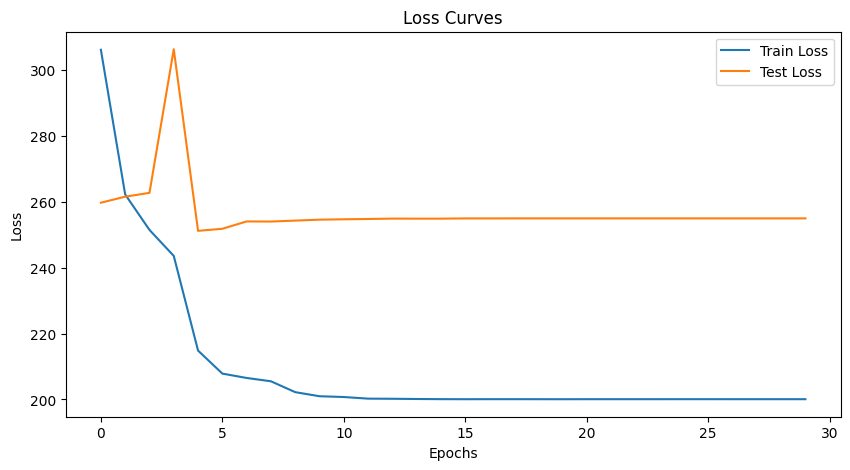

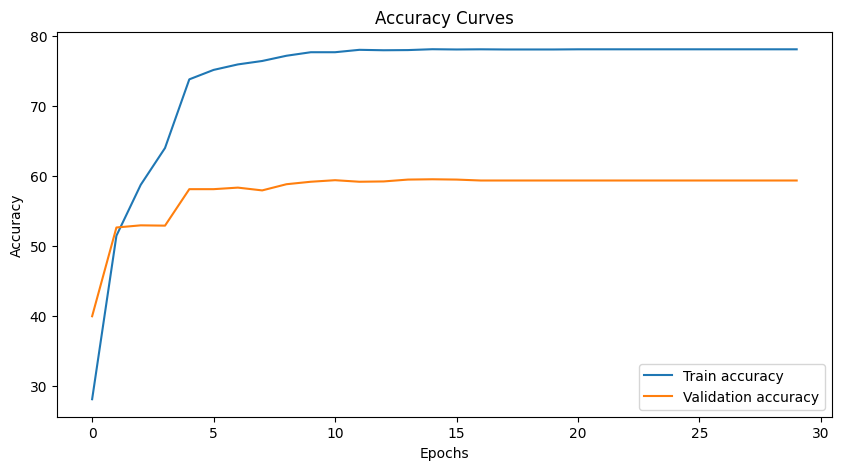

In [42]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_losses_epoch)
plt.plot(test_losses_epoch)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_accuracies_epoch)
plt.plot(val_accuracies_epoch)
plt.title("Accuracy Curves")
plt.legend(["Train accuracy", "Validation accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## 5 Test and improve the trained SNN

***Optional task:***

Test and improve the accuracy of your SNN classifier. How high accuracy can you achieve? How close to the SHD leader board is your result? Can you benefit from spiking CNNs, LSTMSs, ...?


#### Run validation again on the final model to get the metrics.

In [43]:
total = 0
correct = 0
all_predictions = []
all_targets = []

with torch.no_grad():
  net.eval()
  for data, targets in valloader:
    data, targets = data.to(device), targets.to(device).long()
    data = data.transpose(0,1).squeeze()
 
    # forward pass
    test_spk, _ = net(data)

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()
    
    # Collect all prediction and targets
    all_predictions.extend(predicted.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

Accuracy: 0.5940812720848057
Precision: 0.6557760849886932
Recall: 0.5940812720848057
F1-Score: 0.5957523845166366


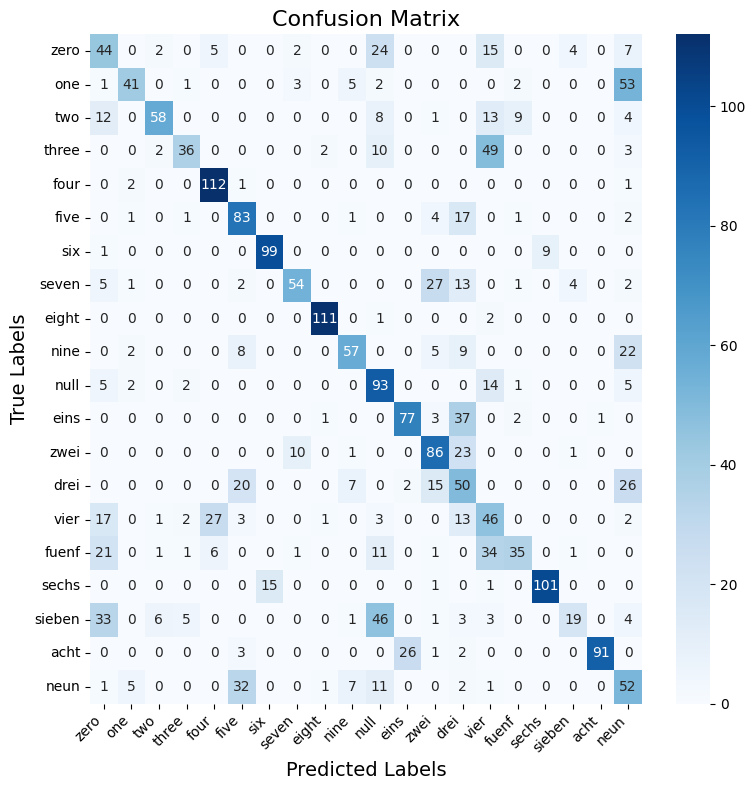

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

"""
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
"""
print("Accuracy:", accuracy_score(all_targets, all_predictions))
print("Precision:", precision_score(all_targets, all_predictions, average="weighted", zero_division=0))
print("Recall:", recall_score(all_targets, all_predictions, average="weighted", zero_division=0))
print("F1-Score:", f1_score(all_targets, all_predictions, average="weighted", zero_division=0))

# Compute confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Plot with seaborn
labels = []
for i in dataset.classes:
    labels.append(i.decode('UTF-8'))
    
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Rotate and pad x-axis labels
plt.xticks(rotation=45, ha="right")

# Set labels and title
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

## References

The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks;
[https://doi.org/10.1109/TNNLS.2020.3044364](https://doi.org/10.1109/TNNLS.2020.3044364).

Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-Based Optimization to Spiking Neural Networks; [https://doi.org/10.1109/MSP.2019.2931595](https://doi.org/10.1109/MSP.2019.2931595).

Training Spiking Neural Networks Using Lessons From Deep Learning; [https://doi.org/10.1109/JPROC.2023.3308088](https://doi.org/10.1109/JPROC.2023.3308088).